In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from nmc import nmc

In [2]:
x0 = np.array([[8, 0, 30]]).T
end_time = 10
dt = 0.01
ts = np.arange(0, end_time, dt)

nature = lorenz63_fdm(x0, ts)
nature.shape

(3, 1000)

In [3]:
Pb = nmc(lorenz63_fdm, nature, dt, 1, 0.04)
Pb

array([[ 5.62829719,  6.44447857, -2.02667547],
       [ 6.44447857,  8.5673791 , -3.13856223],
       [-2.02667547, -3.13856223,  3.33622461]])

In [4]:
obs_intv = 8
obs = nature + np.sqrt(2) * np.random.randn(*nature.shape)
obs = obs[:,::obs_intv]
obs.shape

(3, 125)

In [5]:
R = np.eye(3) * 2
R

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

In [6]:
# a very bad initial condition
X_ini = x0 + np.array([[10, -10, 15]]).T
X_ini

array([[ 18],
       [-10],
       [ 45]])

In [7]:
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)
X_ens_ini.shape

(3, 30)

In [8]:
def da_rmse(nature, analysis, obs_intv):
    return np.sqrt(np.mean((analysis[:,::obs_intv] - nature[:,::obs_intv]) ** 2, axis=0))

def plot_assimilation_result(nature, obs, analysis, obs_intv):
    fig, axs = plt.subplots(nrows=4, figsize=(8, 8), sharex=True)
    for i in range(3):
        axs[i].plot(ts, nature[i,:], color='#024BC7', label='nature')
        axs[i].plot(ts[::obs_intv], obs[i,:], '.', color='#024BC7', label='obs')
        axs[i].plot(ts, analysis[i,:], color='#FFA500', label='analysis')
    axs[0].legend()
    axs[0].set_title('X')
    axs[1].set_title('Y')
    axs[2].set_title('Z')
    
    rmse = da_rmse(nature, analysis, obs_intv)
    axs[3].plot(ts[::obs_intv], rmse, '.-')
    axs[3].set_title('RMSE')
    
    plt.tight_layout()

#### EVD version

In [9]:
from assimilation import EnKF

class ETKF(EnKF):
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_ens = xb.shape[1]
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        
        # assimilate ensemble mean
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        PfH_T = xb_pertb @ Hxb_pertb.T / (N_ens-1)
        HPfH_T = Hxb_pertb @ Hxb_pertb.T / (N_ens-1)
        K = PfH_T @ np.linalg.inv(HPfH_T + R)
        xa_mean = xb_mean + K @ (yo - H_func(xb_mean))
        
        # assimilate ensemble deviation    
        Y = Hxb_pertb   # (ndim_yo, N_ens)
        WW_T = np.linalg.inv(np.eye(N_ens) - Y.T @ np.linalg.inv(R) @ Y)
        
        D, U = np.linalg.eig(WW_T)
        D = np.diag(D)
        
        W = U @ np.sqrt(D) @ U.T
        xa_pertb = xb_pertb @ W
        
        xa = xa_mean + xa_pertb
        return xa

In [10]:
etkf = ETKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4,
}
etkf.set_params(**params)
etkf.cycle()

C:\Users\ChunYehLu\work\SideProject\Data-Assimilation\model.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  x[0] = x0[0]
C:\Users\ChunYehLu\work\SideProject\Data-Assimilation\model.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  y[0] = x0[1]
C:\Users\ChunYehLu\work\SideProject\Data-Assimilation\model.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  z[0] = x0[2]
C:\Users\ChunYehLu\AppData\Local\Continuum\anaconda3\envs\as\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


LinAlgError: Array must not contain infs or NaNs

#### SVD version

In [11]:
from assimilation import EnKF

class ETKF(EnKF):
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_ens = xb.shape[1]
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        
        # assimilate ensemble mean
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        PfH_T = xb_pertb @ Hxb_pertb.T / (N_ens-1)
        HPfH_T = Hxb_pertb @ Hxb_pertb.T / (N_ens-1)
        K = PfH_T @ np.linalg.inv(HPfH_T + R)
        xa_mean = xb_mean + K @ (yo - H_func(xb_mean))
        
        # assimilate ensemble deviation    
        Y = Hxb_pertb   # (ndim_yo, N_ens)
        Y_tilt = np.linalg.inv(np.sqrt(R)) @ Y
        U, S, VT = np.linalg.svd(Y_tilt, full_matrices=False)
        S = np.diag(S)
        D = np.eye(S.shape[0]) + S.T @ S
        W = VT.T @ np.linalg.inv(np.sqrt(D)) @ VT
        xa_pertb = xb_pertb @ W
        
        xa = xa_mean + xa_pertb
        return xa

In [12]:
etkf = ETKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4,
}
etkf.set_params(**params)
etkf.cycle()

Mean RMSE:  8.749889006694449


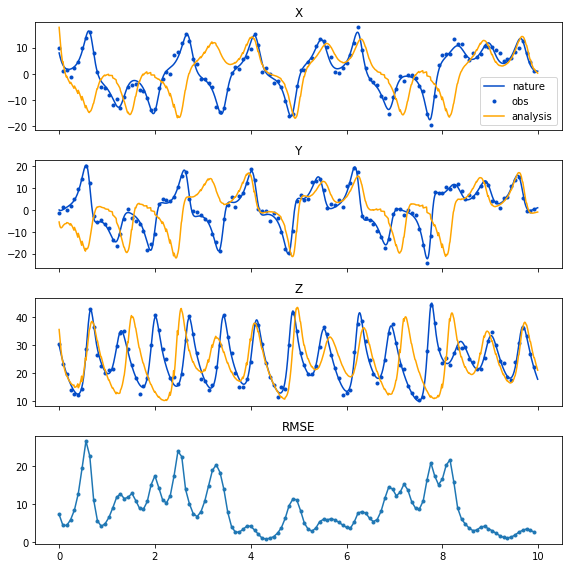

In [13]:
analysis = etkf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

### other paper method

In [14]:
from scipy.linalg import sqrtm
from assimilation import EnKF

class ETKF(EnKF):
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_ens = xb.shape[1]
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        
        # assimilate ensemble mean
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        
        P_tilt = np.linalg.inv(Hxb_pertb.T @ np.linalg.inv(R) @ Hxb_pertb + (N_ens-1) * np.eye(N_ens))
        w = P_tilt @ Hxb_pertb.T @ np.linalg.inv(R) @ (yo - Hxb_mean)
        xa_mean = xb_mean + xb_pertb @ w
        
        # assimilate ensemble perturbation
        Z = xb_pertb / np.sqrt(N_ens-1)
        HZ = Hxb_pertb / np.sqrt(N_ens-1)
        eigval, C = np.linalg.eig(HZ.T @ np.linalg.inv(R) @ HZ)
        S = np.diag(eigval)
        T = C @ np.linalg.inv(sqrtm(S+np.eye(N_ens)))
        T = T.real   # imag part is likely due to numerical error
        xa_pertb = xb_pertb @ T
        
        xa = xa_mean + xa_pertb
        return xa

In [15]:
etkf = ETKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
etkf.set_params(**params)
etkf.cycle()

Mean RMSE:  0.8890681156659243


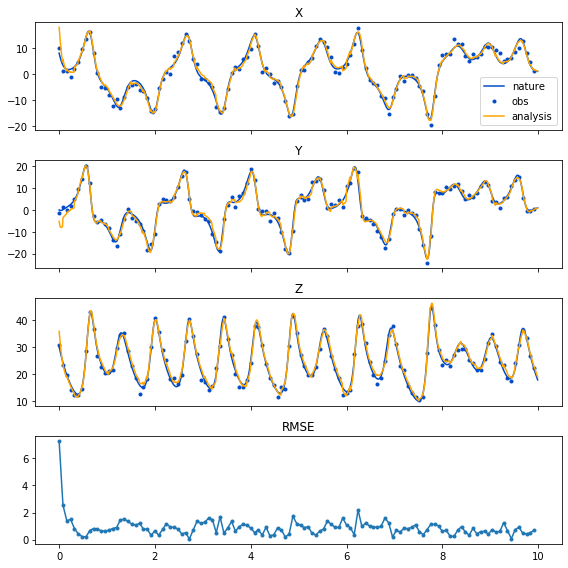

In [16]:
analysis = etkf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

### check mean update (using normal kalman matrix to update instead of using w vector)

In [17]:
from scipy.linalg import sqrtm
from assimilation import EnKF

class ETKF(EnKF):
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_ens = xb.shape[1]
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        
        # assimilate ensemble mean
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        PfH_T = xb_pertb @ Hxb_pertb.T / (N_ens-1)
        HPfH_T = Hxb_pertb @ Hxb_pertb.T / (N_ens-1)
        K = PfH_T @ np.linalg.inv(HPfH_T + R)
        xa_mean = xb_mean + K @ (yo - H_func(xb_mean))
        
        # assimilate ensemble perturbation
        Z = xb_pertb / np.sqrt(N_ens-1)
        HZ = Hxb_pertb / np.sqrt(N_ens-1)
        eigval, C = np.linalg.eig(HZ.T @ np.linalg.inv(R) @ HZ)
        S = np.diag(eigval)
        T = C @ np.linalg.inv(sqrtm(S+np.eye(N_ens)))
        T = T.real   # imag part is likely due to numerical error
        xa_pertb = xb_pertb @ T
        
        xa = xa_mean + xa_pertb
        return xa

In [18]:
etkf = ETKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
etkf.set_params(**params)
etkf.cycle()

Mean RMSE:  0.9880733640060873


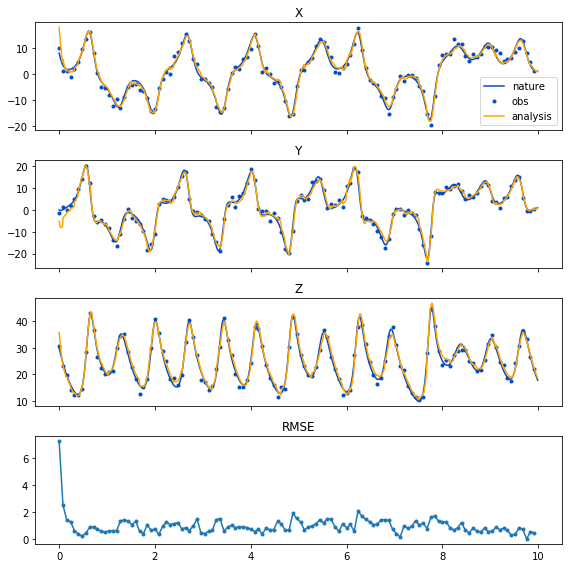

In [19]:
analysis = etkf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

### altogether

In [41]:
from scipy.linalg import sqrtm
from assimilation import EnKF

class ETKF(EnKF):
    """
    Ensemble Transform Kalman Filter
    
    It should note that localization is only used for updating ensemble mean 
    of K method (e.g etkf.cycle(mean_method='K')). There is no localization
    for w method (e.g etkf.cycle(mean_method='w')).
    
    And localization is for ensemble mean only, there is no localization for 
    updating ensemble perturbation.
    
    *Reference
    Update ensemble mean of w method:
        Harlim and Hunt: Local Ensemble Transform Kalman Filter: An efficient
        scheme for assimilating atmospheric data.
        https://www.atmos.umd.edu/~ekalnay/pubs/harlim_hunt05.pdf
    Update ensemble perturbation:
        Tippett, M. K., J. L. Anderson, C. H. Bishop, T. M. Hamill, and J. S. 
        Whitaker, 2003: Ensemble square root filters.
        https://journals.ametsoc.org/doi/pdf/10.1175/1520-0493%282003%29131%3C1485%3AESRF%3E2.0.CO%3B2      
    """
    
    def _analysis_mean_w(self, xb_mean, xb_pertb, Hxb_mean, Hxb_pertb, N_ens, yo, R):
        """
        Using the w vector in Harlim and Hunt* to update background ensemble
        mean to analysis mean.
        *Reference: 
        https://www.atmos.umd.edu/~ekalnay/pubs/harlim_hunt05.pdf
        """
        P_tilt = np.linalg.inv(Hxb_pertb.T @ np.linalg.inv(R) @ Hxb_pertb + (N_ens-1) * np.eye(N_ens))
        w = P_tilt @ Hxb_pertb.T @ np.linalg.inv(R) @ (yo - Hxb_mean)
        xa_mean = xb_mean + xb_pertb @ w
        return xa_mean
    
    def _analysis_mean_K(self, xb_mean, xb_pertb, Hxb_pertb, N_ens, yo, R, H_func, loc_mo, loc_oo):
        """
        Using the K matrix (Kalman gain matrix) in traditional Kalman filter to
        upate background ensemble mean to analysis ensemble mean.
        """
        PfH_T = xb_pertb @ Hxb_pertb.T / (N_ens-1)
        HPfH_T = Hxb_pertb @ Hxb_pertb.T / (N_ens-1)
        K = loc_mo * PfH_T @ np.linalg.inv(loc_oo * HPfH_T + R)
        xa_mean = xb_mean + K @ (yo - H_func(xb_mean))
        return xa_mean
    
    def _analysis_perturb(self, xb_pertb, Hxb_pertb, N_ens, R):
        """
        Update background ensemble perturbation tp analysis ensemble perturbation.
        *Reference:
        https://journals.ametsoc.org/doi/pdf/10.1175/1520-0493%282003%29131%3C1485%3AESRF%3E2.0.CO%3B2
        """
        Z = xb_pertb / np.sqrt(N_ens-1)
        HZ = Hxb_pertb / np.sqrt(N_ens-1)
        eigval, C = np.linalg.eig(HZ.T @ np.linalg.inv(R) @ HZ)
        S = np.diag(eigval)
        T = C @ np.linalg.inv(sqrtm(S+np.eye(N_ens)))
        T = T.real   # imag part is likely due to numerical error
        xa_pertb = xb_pertb @ T
        return xa_pertb
        
    def _analysis(self, xb, yo, R, H_func=None, loc_mo=None, loc_oo=None, mean_method='w'):
        if H_func is None:
            H_func = lambda arr: arr
            
        N_ens = xb.shape[1]
        xb_mean = xb.mean(axis=1)[:,np.newaxis]   # (ndim_xb, 1)
        xb_pertb = xb - xb_mean   # (ndim_xb, N_ens)
        Hxb_mean = H_func(xb).mean(axis=1)[:,np.newaxis]   # (ndim_yo, 1)
        Hxb_pertb = H_func(xb) - Hxb_mean   # (ndim_yo, N_ens)
        
        if mean_method == 'w':
            xa_mean = self._analysis_mean_w(xb_mean, xb_pertb, Hxb_mean, Hxb_pertb, N_ens, yo, R)
        elif mean_method == 'K':
            xa_mean = self._analysis_mean_K(xb_mean, xb_pertb, Hxb_pertb, N_ens, yo, R, H_func, loc_mo, loc_oo)
        else:
            raise TypeError('`mean_method` should be "w" or "K"')
            
        xa_pertb = self._analysis_perturb(xb_pertb, Hxb_pertb, N_ens, R)
        xa = xa_mean + xa_pertb
        return xa
    
    def cycle(self, mean_method='w'):
        super().cycle(mean_method=mean_method)

In [46]:
etkf = ETKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
}
etkf.set_params(**params)
etkf.cycle(mean_method='w')

Mean RMSE:  0.8890681156659243


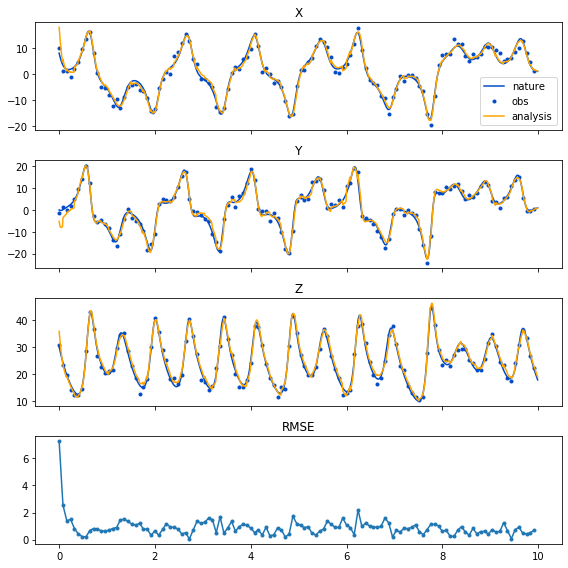

In [47]:
analysis = etkf.analysis.mean(axis=0)
plot_assimilation_result(nature, obs, analysis, obs_intv)
print('Mean RMSE: ', da_rmse(nature, analysis, obs_intv).mean())

### test localization

In [49]:
from model import lorenz96_fdm

x0 = np.random.randint(low=0, high=9, size=40)
x0 = x0[:,np.newaxis]  # (40, 1)
end_time = 10
dt = 0.01
ts = np.arange(0, end_time, dt)
nature = lorenz96_fdm(x0, ts)

Pb = nmc(lorenz96_fdm, nature, dt, 1, 0.1)

obs_intv = 8
obs = nature + np.sqrt(2) * np.random.randn(*nature.shape)
obs = obs[:,::obs_intv]

R = np.eye(40) * 2

X_ini = x0 + np.random.randint(-15, 15, size=x0.shape)
N_ens = 30
X_ens_ini = np.random.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (ndim, N_ens)

In [60]:
### no localization
etkf = ETKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5
}
etkf.set_params(**params)
etkf.cycle(mean_method='K')    

Mean RMSE:  2.9308113217921763


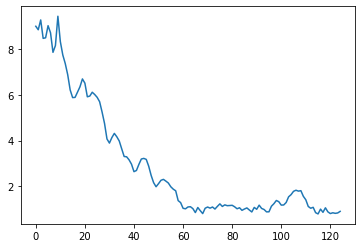

In [61]:
analysis = etkf.analysis.mean(axis=0)
rmse = da_rmse(nature, analysis, obs_intv)
plt.plot(rmse)
print('Mean RMSE: ', rmse.mean())

In [62]:
### localization

def dis_oo(i, j, L=2):
    if j < i:
        i, j = j, i
    dis_idx = j - i
    if dis_idx > 20:
        dis_idx = 40 - dis_idx
    return np.exp(-dis_idx**2 / (2*L**2))

def dis_mo(i, j, L=2):
    return dis_oo(i, j, L)

# localization for model to observation
loc1 = np.zeros((40, 40))
for i in range(40):
    for j in range(40):
        loc1[i,j] = dis_mo(i, j)
        
# localization for observation to observation
loc2 = np.zeros((40, 40))
for i in range(40):
    for j in range(40):
        loc2[i,j] = dis_oo(i, j)

In [63]:
etkf = ETKF(lorenz96_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.4,
    'inflat': 1.5,
    'local_mo': loc1,
    'local_oo': loc2
}
etkf.set_params(**params)
etkf.cycle(mean_method='K')    

Mean RMSE:  1.1291303736235905


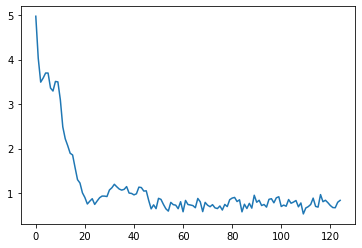

In [64]:
analysis = etkf.analysis.mean(axis=0)
rmse = da_rmse(nature, analysis, obs_intv)
plt.plot(rmse)
print('Mean RMSE: ', rmse.mean())